### Load Required Packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Helper Functions

In [2]:
def extract_layer_output(model, layer_name, data):
    int_layer_op = model.get_layer(name=layer_name).output
    int_layer_model = Model(inputs=model.input, outputs=int_layer_op)
    int_layer_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return int_layer_model.predict(data)

In [3]:
def generate_df(arr, label):
    df = pd.DataFrame(arr)
    df['label'] = label
    return df

### Load Dataset

In [4]:
base_path = './combined-real-and-fake-faces/combined-real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    shuffle=False,
    class_mode='binary'
)

test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle = False,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 21591 images belonging to 2 classes.


In [5]:
y_test = test_flow.classes

### Custom CNN Model Trained without Data Augmentation

In [41]:
custom_model = load_model('./models/custom_model.h5')

**Extract Intermediate Layer to get vector representation of the images**

In [42]:
int_output_custom = extract_layer_output(custom_model, 'global_average_pooling2d_2', train_flow)
int_output_custom.shape

(100000, 512)

In [43]:
int_output_custom = generate_df(int_output_custom, train_flow.classes)
int_output_custom.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,-0.064347,0.315314,-0.082178,-0.025755,-0.281003,-0.103529,-0.587723,0.302197,-0.663875,-0.087050,...,-0.477438,0.646915,0.263131,-0.285801,0.456849,-0.406212,-0.018271,-0.663158,-0.047162,0
1,-0.410897,0.522355,-0.400635,0.175051,-0.147669,-0.872083,-0.460753,0.084436,-0.940394,0.506296,...,-0.393439,0.329348,0.814919,0.216584,1.280293,-0.577599,0.302288,-0.344008,-0.502761,0
2,-0.251155,0.118344,-0.266196,0.677790,0.041686,-0.112833,0.127713,-0.217330,0.072790,-0.524414,...,-0.067237,0.062571,0.621387,-0.352184,0.670028,-0.350742,0.364200,-0.514007,-0.300528,0
3,0.222398,-0.218359,0.383936,0.153219,-0.098354,0.073822,0.110539,-0.092081,-0.178362,-0.004538,...,-0.588407,-0.568026,-0.143572,-0.272199,0.366902,0.160762,-0.033085,-0.239038,-0.126651,0
4,0.183681,-0.066100,-0.122989,0.393513,0.017248,-0.118713,-0.398579,-0.478918,-0.682844,-0.328338,...,-0.331310,-0.533369,0.242846,0.249581,0.514697,-0.700496,-0.551554,-0.246926,0.493305,0


In [44]:
int_output_custom.tail()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
99995,-0.089288,0.833943,0.496964,0.070839,0.518653,0.085650,-0.053947,0.478515,0.447147,0.096622,...,-0.422173,-0.094132,-0.425031,-0.277148,-0.262223,-0.757819,-0.681665,-0.357625,0.334255,1
99996,-0.331002,0.391423,-0.152171,-0.390738,0.561211,-0.155781,-0.143798,0.121341,0.120239,-0.219949,...,-0.114641,-0.454296,-0.034132,-0.311504,0.066938,0.498823,-0.577538,-0.018172,-0.499409,1
99997,0.039749,0.093933,0.107311,0.022725,0.179152,-0.198624,-0.035209,-0.580543,0.073251,-0.003496,...,0.042569,-0.385051,-0.234829,-0.049090,-0.116156,-0.186047,-0.482308,-0.198769,-0.111822,1
99998,-0.128864,-0.252888,0.369332,-0.527870,-0.260254,-0.479102,-0.867311,-0.661224,-0.870771,-0.623374,...,-0.172046,0.190163,0.507643,0.275005,-0.210565,-1.013972,-0.977299,-0.968776,0.501190,1
99999,0.341368,-0.006963,0.415988,0.522094,0.434684,-0.613197,-0.352261,-0.274451,-0.284514,0.187608,...,0.754175,-0.669705,0.340024,0.326100,0.426588,-0.917124,-0.308596,-0.362329,0.549733,1


In [60]:
int_output_custom.to_csv('./custom_model_rep.csv', index=False)

**Predictions**

In [46]:
y_pred_custom = custom_model.predict(test_flow)

**Evaluation Report**

In [47]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_custom))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_custom))
print()
print(metrics.classification_report(y_test, y_pred_custom > 0.5))

ROC AUC Score: 0.9312318194158942
AP Score: 0.8535236743509741

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     10735
           1       0.91      0.87      0.89     10856

    accuracy                           0.89     21591
   macro avg       0.89      0.89      0.89     21591
weighted avg       0.89      0.89      0.89     21591



___
### Custom CNN Model Trained with Data Augmentation

In [51]:
custom_aug_model = load_model('./models/custom_augmented_model.h5')

**Extract Intermediate Layer to get vector representation of the images**

In [56]:
int_output_cus_aug = extract_layer_output(custom_aug_model, 'global_average_pooling2d_1', train_flow)
int_output_cus_aug.shape

(100000, 512)

In [57]:
int_output_cus_aug = generate_df(int_output_cus_aug, train_flow.classes)
int_output_cus_aug.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,-0.017101,0.885686,-0.206420,0.283040,-0.121395,-0.358216,-0.420807,-0.550607,-0.347103,0.535289,...,-0.019779,0.647270,-0.466116,0.167784,0.829289,0.095351,-0.221278,0.108078,-0.683688,0
1,-0.616731,0.011787,-0.410894,0.084567,0.700409,-1.037436,-0.508460,-0.341633,-0.771044,-0.160580,...,0.004292,1.246933,-0.556611,0.584986,0.658404,0.332848,-0.905966,-0.131904,-0.395897,0
2,-0.274920,-0.014682,-0.041858,-0.123103,0.248957,-0.517080,0.786235,-0.176524,0.273294,-0.073755,...,0.295115,0.739535,-0.161504,0.851662,-0.122218,0.321281,-0.033626,-0.395039,0.434099,0
3,-0.348018,0.370128,-0.320590,-0.057117,0.113984,-0.385867,-0.334137,-0.477719,-0.665843,-0.402417,...,-0.460846,0.010843,-0.683012,0.355569,0.622504,0.286583,-0.750954,-0.046315,-0.189408,0
4,-0.347996,-0.393727,0.227899,0.260345,0.446264,0.187147,0.312687,0.497135,-0.019965,-0.178718,...,0.101567,0.673060,-0.740653,0.480845,-0.030087,0.416027,-0.116647,-0.174651,0.693389,0


In [58]:
int_output_cus_aug.tail()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
99995,-0.514666,-0.398696,-0.305452,-0.243991,0.593126,-0.164856,0.045968,-0.179645,0.627564,-0.127338,...,-0.801149,-0.299302,0.016369,-0.224407,-0.512632,-0.927466,0.131101,-0.398287,0.386012,1
99996,0.522300,1.162689,0.234808,-0.628048,-0.744579,-0.714863,-0.007249,-0.231742,0.033815,0.589651,...,-0.478752,-1.017375,0.252435,-0.632191,-0.227130,-0.164177,-0.038639,-0.033343,-0.269384,1
99997,0.260516,-0.816823,0.352308,-0.202175,-0.129777,-0.191991,0.452111,0.409364,-0.306173,-0.350385,...,-0.307918,-0.092452,0.269001,-0.016173,0.410018,0.849291,-0.733205,-0.111412,0.343142,1
99998,-0.644425,0.278323,-0.017994,0.053283,0.155392,0.742664,-0.598230,0.452784,-0.062948,-0.337067,...,0.348335,0.292711,-0.634188,0.154389,0.274274,0.242626,-0.405740,-0.680404,0.622508,1
99999,-0.739460,-0.448386,-0.308363,0.179362,0.682445,-0.201325,0.481470,0.122322,0.641392,-0.687328,...,-0.381200,0.401947,-0.412892,1.160267,-0.207341,-0.049771,-0.090701,-0.916294,0.646585,1


In [61]:
int_output_cus_aug.to_csv('./custom_augmented_model_rep.csv', index=False)

**Predictions**

In [62]:
y_pred_cus_agg = custom_aug_model.predict(test_flow)

**Evaluation Report**

In [63]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_cus_agg))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_cus_agg))
print()
print(metrics.classification_report(y_test, y_pred_cus_agg > 0.5))

ROC AUC Score: 0.907933161694318
AP Score: 0.8472840017218062

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     10735
           1       0.87      0.79      0.83     10856

    accuracy                           0.84     21591
   macro avg       0.84      0.84      0.84     21591
weighted avg       0.84      0.84      0.84     21591



___
### VGGFace Fine Tuned Model without Data Augmentation

In [6]:
vggface = load_model('./models/vggface_v1.h5')

**Extract Intermediate Layer to get vector representation of the images**

In [9]:
int_output_vgg = extract_layer_output(vggface, 'fc1', train_flow)
int_output_vgg.shape

(100000, 2048)

In [10]:
int_output_vgg = generate_df(int_output_vgg, train_flow.classes)
int_output_vgg.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
0,0.0,0.847519,0.724391,0.0,0.0,1.018900,0.0,0.0,0.0,0.592672,...,0.594139,0.0,0.874365,0.0,0.730746,0.0,0.0,0.0,0.0,0
1,0.0,1.504278,1.343664,0.0,0.0,1.875045,0.0,0.0,0.0,1.099996,...,1.133855,0.0,1.619812,0.0,1.195965,0.0,0.0,0.0,0.0,0
2,0.0,1.414378,1.264059,0.0,0.0,1.752962,0.0,0.0,0.0,1.079500,...,1.105139,0.0,1.558315,0.0,1.165056,0.0,0.0,0.0,0.0,0
3,0.0,0.820791,0.721580,0.0,0.0,1.061604,0.0,0.0,0.0,0.570302,...,0.631258,0.0,0.839116,0.0,0.655513,0.0,0.0,0.0,0.0,0
4,0.0,1.089702,0.941631,0.0,0.0,1.313845,0.0,0.0,0.0,0.764574,...,0.774959,0.0,1.141736,0.0,0.919725,0.0,0.0,0.0,0.0,0


In [11]:
int_output_vgg.tail()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.134997,0.0,0.0,0.0,0.0,0.0,0.437865,0.0,1
99996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.469873,0.0,0.0,0.0,0.0,0.0,0.699707,0.0,1
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.289712,0.0,0.0,0.0,0.0,0.0,0.501795,0.0,1
99998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.159435,0.0,0.0,0.0,0.0,0.0,0.424813,0.0,1
99999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.285008,0.0,1


In [12]:
int_output_vgg.to_csv('./vggface_rep.csv', index=False)

**Predictions**

In [13]:
y_pred_vgg = vggface.predict(test_flow)

**Evaluation Report**

In [14]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_vgg))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_vgg))
print()
print(metrics.classification_report(y_test, y_pred_vgg > 0.5))

ROC AUC Score: 0.9600932210254477
AP Score: 0.9325796549056171

              precision    recall  f1-score   support

           0       0.97      0.92      0.94     10735
           1       0.93      0.97      0.95     10856

    accuracy                           0.95     21591
   macro avg       0.95      0.95      0.95     21591
weighted avg       0.95      0.95      0.95     21591



___
### DenseNet Model Trained without Data Augmentation

In [15]:
densenet_v1 = load_model('./models/densenet_v1.h5')

**Extract Intermediate Layer to get vector representation of the images**

In [16]:
int_output_dv1 = extract_layer_output(densenet_v1, 'global_average_pooling2d', train_flow)
int_output_dv1.shape

(100000, 1024)

In [17]:
int_output_dv1 = generate_df(int_output_dv1, train_flow.classes)
int_output_dv1.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0.280332,0.071319,0.290553,0.340185,0.522443,0.664085,0.501311,0.319497,0.418953,0.619749,...,0.517286,0.200696,0.549189,0.502353,0.347513,0.522260,0.155741,0.162449,0.288870,0
1,0.183173,0.082026,0.221390,0.335868,0.412098,0.557626,0.392902,0.319508,0.260044,0.514430,...,0.443096,0.184226,0.484547,0.439558,0.296033,0.510709,0.146062,0.307765,0.282705,0
2,0.306966,0.028815,0.208510,0.338645,0.380179,0.512343,0.371461,0.284346,0.558514,0.460414,...,0.343907,0.125783,0.373969,0.345774,0.312796,0.371904,0.071682,0.141716,0.196437,0
3,0.164646,0.053577,0.138079,0.182050,0.269746,0.357534,0.267633,0.154713,0.306458,0.323547,...,0.164306,0.030136,0.173777,0.166105,0.174043,0.182507,0.003204,0.097136,0.067782,0
4,0.274487,0.047566,0.233368,0.312017,0.440843,0.567504,0.430719,0.298505,0.526158,0.527211,...,0.464798,0.179264,0.475700,0.446901,0.421227,0.426989,0.138764,0.274363,0.257648,0


In [18]:
int_output_dv1.tail()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
99995,0.247740,0.048858,0.034092,0.156509,0.092039,0.098219,0.093814,0.073495,0.418897,0.070975,...,0.006717,0.000000,0.005063,0.001984,0.142422,0.004966,0.000000,0.091542,0.000000,1
99996,0.166594,0.085349,0.007205,0.126247,0.031711,0.028504,0.021576,0.047941,0.260957,0.013486,...,0.000730,0.000000,0.000000,0.000000,0.176630,0.000000,0.000000,0.110408,0.000000,1
99997,0.245655,0.050536,0.000000,0.236500,0.000000,0.002336,0.000149,0.091581,0.326663,0.000000,...,0.021405,0.017917,0.023024,0.021247,0.470571,0.053040,0.104478,0.535990,0.032849,1
99998,0.194670,0.051522,0.013928,0.181728,0.032735,0.037647,0.036570,0.100740,0.317533,0.026759,...,0.000000,0.000000,0.000000,0.000000,0.201610,0.002224,0.000000,0.209803,0.000000,1
99999,0.237341,0.030115,0.027945,0.239910,0.071306,0.099464,0.073482,0.181533,0.390559,0.092659,...,0.049324,0.003451,0.051871,0.044997,0.199534,0.042105,0.006861,0.237598,0.003288,1


In [19]:
int_output_dv1.to_csv('./densenet_v1_rep.csv', index=False)

**Predictions**

In [20]:
y_pred_dv1 = densenet_v1.predict(test_flow)

**Evaluation Report**

In [21]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_dv1))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_dv1))
print()
print(metrics.classification_report(y_test, y_pred_dv1 > 0.5))

ROC AUC Score: 0.9565295476644934
AP Score: 0.9201108482795977

              precision    recall  f1-score   support

           0       0.96      0.91      0.93     10735
           1       0.92      0.96      0.94     10856

    accuracy                           0.94     21591
   macro avg       0.94      0.93      0.94     21591
weighted avg       0.94      0.94      0.94     21591



___
### DenseNet Model Trained with Data Augmentation

In [22]:
densenet_v2 = load_model('./models/completed_augmented_trained_model.h5')

In [23]:
int_output_dv2 = extract_layer_output(densenet_v2, 'global_average_pooling2d', train_flow)
int_output_dv2.shape

(100000, 1024)

In [24]:
int_output_dv2 = generate_df(int_output_dv2, train_flow.classes)
int_output_dv2.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0.007733,0.308077,0.179216,0.226038,0.011687,0.033950,0.068752,0.012405,0.017951,0.006271,...,0.138699,0.139463,0.034762,0.012312,0.032738,0.042244,0.070153,0.040713,0.000000,0
1,0.000000,0.172728,0.137209,0.251077,0.022890,0.079947,0.028373,0.053193,0.089327,0.010746,...,0.005464,0.004107,0.097207,0.000000,0.115579,0.107559,0.121534,0.113003,0.000000,0
2,0.173725,0.234279,0.130502,0.102781,0.176708,0.200163,0.103589,0.045222,0.078049,0.118724,...,0.000000,0.000000,0.525753,0.000000,0.505240,0.461878,0.522006,0.546764,0.000872,0
3,0.001673,0.087842,0.134919,0.146676,0.050943,0.081155,0.058619,0.034621,0.121339,0.007844,...,0.123320,0.130635,0.011787,0.016820,0.017439,0.012898,0.038882,0.012645,0.000000,0
4,0.349492,0.119816,0.090997,0.101662,0.372251,0.375042,0.086264,0.097567,0.244376,0.306474,...,0.188555,0.176222,0.010226,0.022402,0.009612,0.014992,0.045365,0.012990,0.000000,0


In [25]:
int_output_dv2.tail()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
99995,0.007817,0.056224,0.140868,0.178844,0.035814,0.067317,0.053892,0.045024,0.050506,0.003240,...,0.339615,0.365875,0.000000,0.051119,0.000006,0.001524,0.004344,0.000000,0.0,1
99996,0.015979,0.308204,0.085681,0.167717,0.051222,0.035701,0.075214,0.076101,0.142398,0.008909,...,0.278237,0.275099,0.007384,0.039792,0.007786,0.013853,0.019550,0.008079,0.0,1
99997,0.000032,0.116553,0.057942,0.129742,0.026495,0.015593,0.058353,0.007719,0.207266,0.002220,...,0.564847,0.572360,0.000000,0.079895,0.000000,0.000000,0.000549,0.000000,0.0,1
99998,0.000000,0.102807,0.077523,0.156468,0.021161,0.055570,0.056154,0.050333,0.158036,0.013285,...,0.438286,0.461540,0.000000,0.057126,0.000000,0.000000,0.000000,0.000000,0.0,1
99999,0.000000,0.063047,0.131515,0.155310,0.128023,0.123048,0.043221,0.096711,0.155520,0.006480,...,0.095271,0.103567,0.004075,0.006800,0.001699,0.007196,0.025675,0.006080,0.0,1


In [26]:
int_output_dv2.to_csv('./augmented_densenet_rep.csv', index=False)

**Predictions**

In [27]:
y_pred_dv2 = densenet_v2.predict(test_flow)

**Evaluation Report**

In [28]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_dv2))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_dv2))
print()
print(metrics.classification_report(y_test, y_pred_dv2 > 0.5))

ROC AUC Score: 0.8713568040133463
AP Score: 0.8531290555629062

              precision    recall  f1-score   support

           0       0.92      0.50      0.65     10735
           1       0.66      0.95      0.78     10856

    accuracy                           0.73     21591
   macro avg       0.79      0.73      0.71     21591
weighted avg       0.79      0.73      0.72     21591



___
### DenseNet Model Trained on GrayScale Images

In [29]:
## update train flow and test flow to use grayscale color mode
gs_train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    color_mode='grayscale',
    class_mode='binary'
)

gs_test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    color_mode='grayscale',
    shuffle = False,
    class_mode='binary'
)

gs_ytest = gs_test_flow.classes

Found 100000 images belonging to 2 classes.
Found 21591 images belonging to 2 classes.


In [30]:
densenet_v3 = load_model('./models/grayscale_densenet.h5')

In [31]:
int_output_dv3 = extract_layer_output(densenet_v3, 'global_average_pooling2d', gs_train_flow)
int_output_dv3.shape

(100000, 1024)

In [32]:
int_output_dv3 = generate_df(int_output_dv3, gs_train_flow.classes)
int_output_dv3.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0.414529,0.175976,0.095803,0.310555,0.322692,0.380952,0.444872,0.054188,0.453329,0.244413,...,0.679426,0.894111,0.675123,0.908890,0.007420,0.043818,0.019302,0.070596,0.913934,0
1,0.370391,0.211070,0.060519,0.184226,0.225421,0.251126,0.403371,0.033979,0.287812,0.147493,...,0.470601,0.645039,0.468310,0.689303,0.000430,0.035568,0.011910,0.021756,0.706609,0
2,0.141266,0.227677,0.075993,0.137283,0.321078,0.154649,0.406908,0.039503,0.201645,0.199975,...,0.071512,0.112266,0.069054,0.107850,0.000000,0.648311,0.752640,0.000000,0.108715,0
3,0.382479,0.144771,0.067355,0.300038,0.276331,0.404183,0.499999,0.013849,0.473038,0.215729,...,0.843818,1.143932,0.839693,1.108382,0.027453,0.022176,0.000000,0.116104,1.129797,0
4,0.367230,0.165550,0.062561,0.268029,0.219110,0.336069,0.413858,0.028105,0.377839,0.222069,...,0.586386,0.786428,0.585640,0.780634,0.000963,0.042635,0.013581,0.058412,0.798584,0


In [33]:
int_output_dv3.tail()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
99995,0.192754,0.251515,0.076746,0.243519,0.178318,0.218602,0.273818,0.021992,0.261691,0.099795,...,0.195096,0.299754,0.189364,0.275339,0.000000,0.026833,0.018347,0.000914,0.277786,1
99996,0.348302,0.196883,0.075690,0.258971,0.299307,0.364393,0.397140,0.039209,0.402618,0.230673,...,0.620962,0.795964,0.625078,0.831531,0.001088,0.039773,0.001530,0.055240,0.836867,1
99997,0.150589,0.145887,0.070173,0.076549,0.202291,0.110434,0.378214,0.015665,0.156470,0.199457,...,0.060364,0.095530,0.053732,0.130559,0.000000,0.476348,0.540662,0.000000,0.139037,1
99998,0.168436,0.217703,0.045867,0.200744,0.204450,0.176166,0.378975,0.046548,0.236584,0.243044,...,0.219617,0.311769,0.224463,0.352476,0.000000,0.060311,0.032675,0.000299,0.364894,1
99999,0.141163,0.170443,0.049447,0.119694,0.257018,0.093513,0.402462,0.025809,0.146966,0.236763,...,0.016196,0.038116,0.015373,0.035102,0.000000,0.553219,0.598571,0.000000,0.049867,1


In [34]:
int_output_dv3.to_csv('./grayscale_densenet_rep.csv', index=False)

**Predictions**

In [35]:
y_pred_dv3 = densenet_v3.predict(gs_test_flow)

**Evaluation Report**

In [36]:
print("ROC AUC Score:", metrics.roc_auc_score(gs_ytest, y_pred_dv3))
print("AP Score:", metrics.average_precision_score(gs_ytest, y_pred_dv3))
print()
print(metrics.classification_report(gs_ytest, y_pred_dv3 > 0.5))

ROC AUC Score: 0.9594158735999128
AP Score: 0.9224849866162643

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     10735
           1       0.91      0.99      0.95     10856

    accuracy                           0.94     21591
   macro avg       0.95      0.94      0.94     21591
weighted avg       0.95      0.94      0.94     21591



___
### Comparison

In [64]:
cus_fpr, cus_tpr, _ = metrics.roc_curve(y_test, y_pred_custom)
cus_roc_auc = metrics.auc(cus_fpr, cus_tpr)

cus_agg_fpr, cus_agg_tpr, _ = metrics.roc_curve(y_test, y_pred_cus_agg)
cus_agg_roc_auc = metrics.auc(cus_agg_fpr, cus_agg_tpr)

vgg_fpr, vgg_tpr, _ = metrics.roc_curve(y_test, y_pred_vgg)
vgg_roc_auc = metrics.auc(vgg_fpr, vgg_tpr)

dv1_fpr, dv1_tpr, _ = metrics.roc_curve(y_test, y_pred_dv1)
dv1_roc_auc = metrics.auc(dv1_fpr, dv1_tpr)

dv2_fpr, dv2_tpr, _ = metrics.roc_curve(y_test, y_pred_dv2)
dv2_roc_auc = metrics.auc(dv2_fpr, dv2_tpr)

dv3_fpr, dv3_tpr, _ = metrics.roc_curve(gs_ytest, y_pred_dv3)
dv3_roc_auc = metrics.auc(dv3_fpr, dv3_tpr)

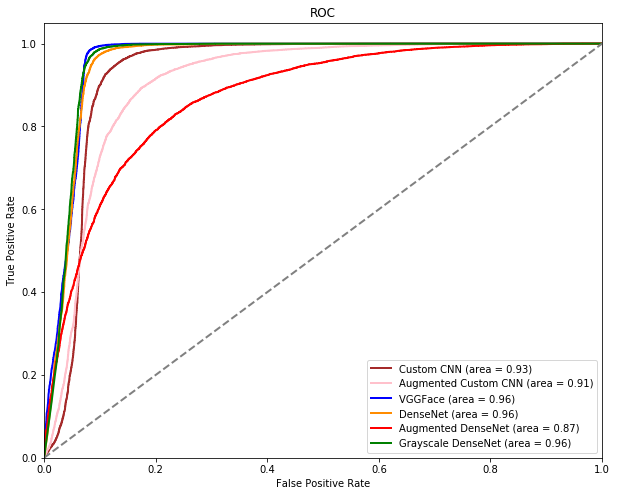

In [65]:
plt.figure(figsize=(10,8))
lw = 2
plt.plot(cus_fpr, cus_tpr, color='brown', lw=lw, label='Custom CNN (area = %0.2f)' % cus_roc_auc)
plt.plot(cus_agg_fpr, cus_agg_tpr, color='pink', lw=lw, label='Augmented Custom CNN (area = %0.2f)' % cus_agg_roc_auc)
plt.plot(vgg_fpr, vgg_tpr, color='blue', lw=lw, label='VGGFace (area = %0.2f)' % vgg_roc_auc)
plt.plot(dv1_fpr, dv1_tpr, color='darkorange', lw=lw, label='DenseNet (area = %0.2f)' % dv1_roc_auc)
plt.plot(dv2_fpr, dv2_tpr, color='red', lw=lw, label='Augmented DenseNet (area = %0.2f)' % dv2_roc_auc)
plt.plot(dv3_fpr, dv3_tpr, color='green', lw=lw, label='Grayscale DenseNet (area = %0.2f)' % dv3_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()